In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from tensorflow.keras.layers import Input, Flatten, Reshape, Dense, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D,Cropping2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K

%matplotlib inline
import pylab as plt

from keras.datasets import mnist

from utiles import *

Using TensorFlow backend.


In [2]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convolutional 2D AEs

In [11]:
def encoder_cnn_2d(x,
                   filters,
                   kernel_size,
                   strides,
                   activation,
                   pool_size,
                   activity_regularizer):
    
    y = Conv2D(filters=filters, 
               kernel_size=kernel_size,
               strides=strides,
               activation=activation,
               padding='same',
               activity_regularizer=activity_regularizer)(x)
    
    if pool_size and pool_size!=(1,1):
        y = MaxPooling2D(pool_size=pool_size,
                         strides=None,
                         padding='same')(y)
    return y

def decoder_cnn_2d(x,
                   filters,
                   kernel_size,
                   strides,
                   activation,
                   upsample_size,
                   activity_regularizer,
                   transpose = False):
    
    if transpose:
        y = Conv2DTranspose(filters = filters,
                            kernel_size = kernel_size,
                            strides = strides,
                            padding='same',
                            dilation_rate = (1, 1),
                            activation = activation,
                            activity_regularizer = activity_regularizer)(x)
    else:
        y = Conv2D(filters = filters, 
                   kernel_size = kernel_size,
                   strides = strides,
                   activation = activation,
                   padding = 'same',
                   activity_regularizer = activity_regularizer)(x)
    
    if upsample_size and upsample_size!=(1,1):
        y = UpSampling2D(size=upsample_size)(y)
        
        

        
    return y

def cond2d_arch_encoder(x_in,
                        latent_dim,
                        n_conv,
                        activation = 'relu',
                        filters = 4,
                        filter_factor = 2,
                        last_filters = None,
                        kernel_size = (5,5),
                        strides = (1,1),
                        pool_size = (2,2),
                        activity_regularizer = None):

    x = x_in

    for _ in range(n_conv-1):
        x = encoder_cnn_2d(x,
                          filters = filters,
                          kernel_size = kernel_size,
                          strides = strides,
                          activation = activation,
                          pool_size = pool_size,
                          activity_regularizer = activity_regularizer)
        filters = int(filters*filter_factor)
        
    if last_filters is None:
        last_filters = filters

    x = encoder_cnn_2d(x,
                       filters = last_filters,
                       kernel_size = kernel_size,
                       strides = strides,
                       activation = activation,
                       pool_size = 0,
                       activity_regularizer = activity_regularizer)

    x_shape = x.get_shape().as_list()

    x = Flatten()(x)

    encoded = Dense(latent_dim,
              activation=activation)(x)
    
    return encoded,x_shape

def cond2d_arch_decoder(encoded,
                        decoded_dim_x,
                        decoded_dim_y,
                        n_conv,
                        x_shape,
                        activation = 'relu',
                        filters = 4,
                        filter_factor = 2,
                        last_filters = 1,
                        kernel_size = (5,5),
                        strides = (1,1),
                        upsample_size = (2,2),
                        activity_regularizer = None,
                        transpose = False):

    x = Dense(x_shape[1]*x_shape[2]*x_shape[3],
              activation=activation)(encoded)

    x = Reshape(x_shape[1:])(x)

    for _ in range(n_conv-1):
        x = decoder_cnn_2d(x,
                           filters = filters,
                           kernel_size = kernel_size,
                           strides = strides,
                           activation = activation,
                           upsample_size = upsample_size,
                           activity_regularizer = activity_regularizer,
                           transpose = transpose)
        filters = int(filters//filter_factor)
        
    decoded = decoder_cnn_2d(x,
                             filters = last_filters,
                             kernel_size = kernel_size,
                             strides = (1,1),
                             activation = activation,
                             upsample_size = 0,
                             activity_regularizer = activity_regularizer,
                             transpose = transpose)
    
    d_shape = decoded.get_shape().as_list()
    delta_x = d_shape[1] - decoded_dim_x
    delta_y = d_shape[2] - decoded_dim_y

    d_crop_x = int(delta_x/2)
    d_crop_y = int(delta_y/2)
    
    if delta_x%2==0:
        d_crop_x = (d_crop_x,d_crop_x)
    else:
        d_crop_x = (d_crop_x,d_crop_x+1)
        
    if delta_y%2==0:
        d_crop_y = (d_crop_y,d_crop_y)
    else:
        d_crop_y = (d_crop_y,d_crop_y+1)
    
    decoded = Cropping2D(cropping=(d_crop_x,d_crop_y))(decoded)
    
    return decoded

#### example:

In [12]:
nx,ny = 25,25
latent_dim = 10
n_conv = 2
activation='relu'
filters=4
kernel_size=5
strides=1
pool_size = 2
upsample_size=2


decoded_dim_x = nx
decoded_dim_y = ny

x_in = Input(shape=(nx, ny, 1)) 

encoded,x_shape = cond2d_arch_encoder(x_in,
                                      latent_dim,
                                      n_conv,
                                      activation = activation,
                                      filters = filters,
                                      kernel_size = kernel_size,
                                      strides = strides,
                                      pool_size = pool_size)

decoded = cond2d_arch_decoder(encoded,
                              decoded_dim_x,
                              decoded_dim_y,
                              n_conv,
                              x_shape,
                              activation = activation,
                              filters = filters,
                              kernel_size = kernel_size,
                              strides = (2,2),
                              upsample_size = 0,
                              transpose=1)

autoencoder = Model(x_in, decoded)
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 25, 25, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 4)         104       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 4)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 8)         808       
_________________________________________________________________
flatten_2 (Flatten)          (None, 1352)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                13530     
_________________________________________________________________
dense_5 (Dense)              (None, 1352)              1487

In [13]:
class ConvolutionalAutoEncoder2D(AutoEncoderBase):
    def __init__(self,
                 input_dim_x,
                 input_dim_y,
                 latent_dim,
                 n_conv = 2,
                 filters = 4,
                 filter_factor = 2,
                 kernel_size = (5,5),
                 strides_en = (1,1),
                 strides_de = (2,2),
                 pool_size = (2,2),
                 upsample_size = False,
                 activation = 'relu',
                 transpose = True,
                 activity_regularizer = None,
                 learning_rate = 0.03,
                 batch_size = 100):
        
        super().__init__(input_dim = None,
                         latent_dim = latent_dim,
                         activation = activation,
                         activity_regularizer = activity_regularizer,
                         learning_rate = learning_rate,
                         batch_size = batch_size)
        
        self.input_dim_x = input_dim_x
        self.input_dim_y = input_dim_y
        self.n_conv = n_conv
        self.filters = filters
        self.filter_factor = filter_factor
        self.kernel_size = kernel_size
        self.strides_en = strides_en
        self.strides_de = strides_de
        self.pool_size = pool_size
        self.upsample_size = upsample_size
        self.transpose = transpose
        self.activity_regularizer = activity_regularizer
        
        self.input = Input(shape=(self.input_dim_x, self.input_dim_y, 1)) 
        self.encoded = self._encode(self.input)
        self.decoded = self._decode(self.encoded)
        self.encoder_index = len(Model(self.input,self.encoded).layers)
#         self.encoder_index = 12
        self.prepare_models()
        
    def _encode(self, x_in):

        encoded,self.x_shape = cond2d_arch_encoder(x_in,
                                                   self.latent_dim,
                                                   self.n_conv,
                                                   activation = self.activation,
                                                   filters = self.filters,
                                                   filter_factor = self.filter_factor,
                                                   kernel_size = self.kernel_size,
                                                   strides = self.strides_en,
                                                   pool_size = self.pool_size,
                                                   activity_regularizer = self.activity_regularizer)

        return encoded
    
    def _decode(self, encoded):

        decoded = cond2d_arch_decoder(encoded,
                                      self.input_dim_x,
                                      self.input_dim_y,
                                      self.n_conv,
                                      self.x_shape,
                                      activation = self.activation,
                                      filters = self.x_shape[-1],
                                      filter_factor = self.filter_factor,
                                      kernel_size = self.kernel_size,
                                      strides = self.strides_de,
                                      upsample_size = self.upsample_size,
                                      activity_regularizer = self.activity_regularizer,
                                      transpose = self.transpose)
        
        return decoded

    def train(self, x, 
              training_epochs=10, 
              lr_sch=True, 
              early_stop=True,
              verbose=True): 
        if x.ndim==3:
            x = np.expand_dims(x,-1)
        super().train(x, 
                      training_epochs=training_epochs, 
                      lr_sch=lr_sch, 
                      early_stop=early_stop,
                      verbose=verbose)
        
    def encoder(self, x):
        if x.ndim==3:
            x = np.expand_dims(x,-1)
        assert (x.shape[1]==self.input_dim_x and x.shape[2]==self.input_dim_y),'Input dimension problem!'
        return self._encoder.predict(x)

In [14]:
cae = ConvolutionalAutoEncoder2D(input_dim_x=28,
                                  input_dim_y=28,
                                  latent_dim=2,
                                  filter_factor=1.5,
                                  n_conv = 3)
cae.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 4)         104       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 6)         606       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 6)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 9)           1359      
_________________________________________________________________
flatten_3 (Flatten)          (None, 441)               0  

In [28]:
cae.train(x_train,training_epochs=5)

Train on 60000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/5
60000/60000 [==============================] - 31s 516us/sample - loss: 0.0942

Epoch 00002: LearningRateScheduler reducing learning rate to 0.05.
Epoch 2/5
60000/60000 [==============================] - 40s 672us/sample - loss: 0.0872

Epoch 00003: LearningRateScheduler reducing learning rate to 0.025.
Epoch 3/5
60000/60000 [==============================] - 37s 623us/sample - loss: 0.0786

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0125.
Epoch 4/5
60000/60000 [==============================] - 33s 553us/sample - loss: 0.0718

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 5/5
60000/60000 [==============================] - 36s 597us/sample - loss: 0.0701


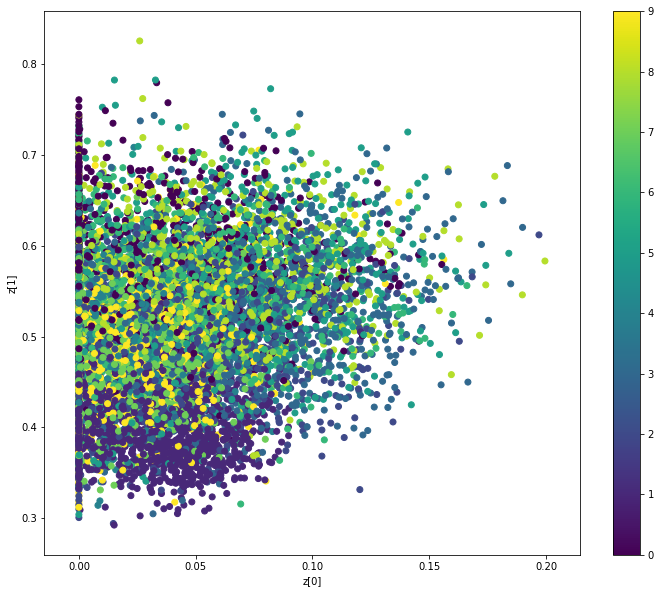

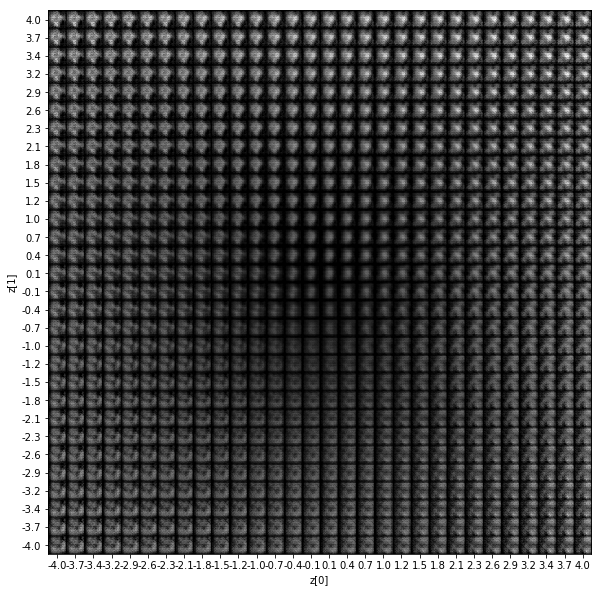

In [29]:
cae.illustration(data=(x_test,y_test))

Train on 10000 samples
------------------------------------------------------------------------------------------
Encoded and decoded shapes are (1, 2), (1, 28, 28, 1).


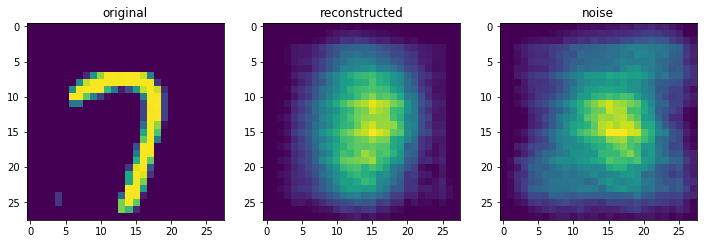

Differece between method and predicdt is 45.456565856933594.
------------------------------------------------------------------------------------------


In [39]:
cae.check(x_test,training_epochs=0,l=28,w=28)

In [17]:
class ConvolutionalVariationalAutoEncoder2D(AutoEncoderBase):
    def __init__(self,
                 input_dim_x,
                 input_dim_y,
                 latent_dim,
                 n_conv = 2,
                 filters = 4,
                 filter_factor = 2,
                 kernel_size = (5,5),
                 strides = (1,1),
                 pool_size = (2,2),
                 upsample_size = False,
                 activation = 'relu',
                 transpose = True,
                 activity_regularizer = None,
                 learning_rate = 0.03,
                 batch_size = 100):
        
        super().__init__(input_dim = None,
                         latent_dim = latent_dim,
                         activation = activation,
                         activity_regularizer = activity_regularizer,
                         learning_rate = learning_rate,
                         batch_size = batch_size,
                         variational = True)
        
        self.input_dim_x = input_dim_x
        self.input_dim_y = input_dim_y
        self.input_dim = input_dim_x*input_dim_y
        self.n_conv = n_conv
        self.filters = filters
        self.filter_factor = filter_factor
        self.kernel_size = kernel_size
        self.strides = strides
        self.pool_size = pool_size
        self.upsample_size = upsample_size
        self.transpose = transpose
        self.activity_regularizer = activity_regularizer
        
        self.input = Input(shape=(self.input_dim_x, self.input_dim_y, 1)) 
        self.encoded,self.z_mean, self.z_log_var = self._encode(self.input)
        self.decoded = self._decode(self.encoded)
        self.encoder_index = len(Model(self.input,self.encoded).layers)
#         self.encoder_index = 12
        self.prepare_models()
        
    def _encode(self, x_in):

        x,self.x_shape = cond2d_arch_encoder(x_in,
                                             2*self.latent_dim,
                                             self.n_conv,
                                             activation = self.activation,
                                             filters = self.filters,
                                             filter_factor = self.filter_factor,
                                             kernel_size = self.kernel_size,
                                             strides = self.strides,
                                             pool_size = self.pool_size,
                                             activity_regularizer = self.activity_regularizer)

        z_mean = Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = Dense(self.latent_dim, name='z_log_var')(x)
        encoded = Lambda(sampling, output_shape=(self.latent_dim,), name='z')([z_mean, z_log_var])

        return encoded, z_mean, z_log_var
    
    def _decode(self, encoded):

        decoded = cond2d_arch_decoder(encoded,
                                      self.input_dim_x,
                                      self.input_dim_y,
                                      self.n_conv,
                                      self.x_shape,
                                      activation = self.activation,
                                      filters = self.x_shape[-1],
                                      filter_factor = self.filter_factor,
                                      kernel_size = self.kernel_size,
                                      strides = self.strides,
                                      upsample_size = self.upsample_size,
                                      activity_regularizer = self.activity_regularizer,
                                      transpose = self.transpose)
        
        return decoded

    def train(self, x, 
              training_epochs=10, 
              lr_sch=True, 
              early_stop=True,
              verbose=True): 
        if x.ndim==3:
            x = np.expand_dims(x,-1)
        super().train(x, 
                      training_epochs=training_epochs, 
                      lr_sch=lr_sch, 
                      early_stop=early_stop,
                      verbose=verbose)
        
    def encoder(self, x):
        if x.ndim==3:
            x = np.expand_dims(x,-1)
        assert (x.shape[1]==self.input_dim_x and x.shape[2]==self.input_dim_y),'Input dimension problem!'
        return self._encoder.predict(x)

In [20]:
cvae2d = ConvolutionalVariationalAutoEncoder2D(input_dim_x = 28,
                                               input_dim_y = 28,
                                               latent_dim = 2,
                                               filters = 16,
                                               n_conv = 2,
                                               transpose = 1)
cvae2d.summary()

W1115 18:00:27.737478 140246724388672 training_utils.py:1348] Output cropping2d_7 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to cropping2d_7.


Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 28, 28, 16)   416         input_14[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 14, 14, 16)   0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 14, 14, 32)   12832       max_pooling2d_10[0][0]           
___________________________________________________________________________________________

In [7]:
cvae2d.train(x_train,training_epochs=20)

Train on 60000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/20
60000/60000 [==============================] - 137s 2ms/sample - loss: 49.8926

Epoch 00002: LearningRateScheduler reducing learning rate to 0.05.
Epoch 2/20
60000/60000 [==============================] - 137s 2ms/sample - loss: 44.0891

Epoch 00003: LearningRateScheduler reducing learning rate to 0.025.
Epoch 3/20
60000/60000 [==============================] - 134s 2ms/sample - loss: 42.9177

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0125.
Epoch 4/20
60000/60000 [==============================] - 134s 2ms/sample - loss: 42.5030

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 5/20
60000/60000 [==============================] - 136s 2ms/sample - loss: 42.3438

Epoch 00006: LearningRateScheduler reducing learning rate to 0.003125.
Epoch 6/20
60000/60000 [==============================] - 139s 2ms/sample - loss: 42.2508

Epoch 00007: Learni

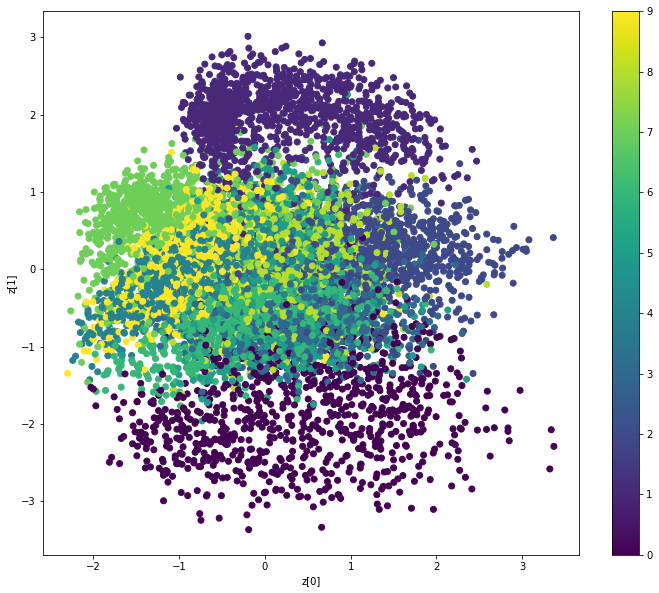

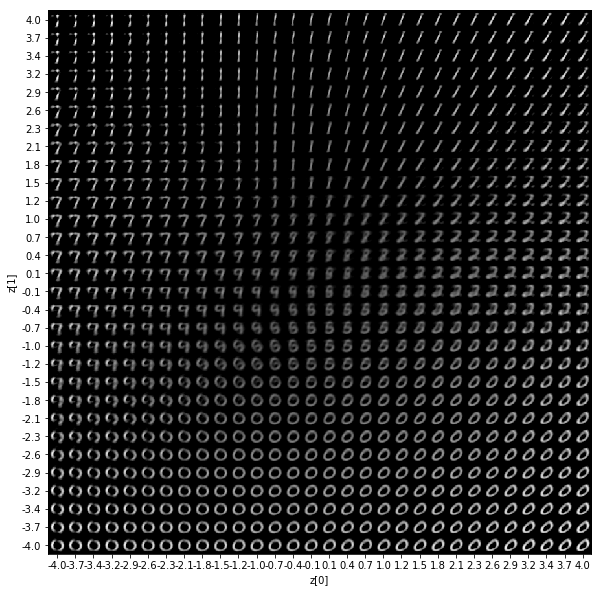

In [10]:
cvae2d.illustration(data=(x_test,y_test))

In [1]:
import numpy as np

def get_slice(x,window):
    if window is None:
        window = x.ndim*[0]
    window = np.array(window)
    shape = np.array(x.shape)
    idx0 = np.random.randint(shape-window)
    slices = []
    for i in range(x.ndim):
        if window[i]!=0:
            slices.append(slice(idx0[i],idx0[i]+window[i]))
        else:
            slices.append(slice(0,shape[i]))
    return slices

def slicer(x,slices):
    slcstr = ','.join(['slices[{}]'.format(i) for i in range(len(slices))])
    xp = eval('x[{}]'.format(slcstr))
    return xp

In [2]:
x = np.random.normal(0,1,(30,10,40,15,20,30))
y = 1-x
window = [3,5,3,4,2,4]

In [3]:
slices = get_slice(x,window)
np.mean(slicer(x,slices)+slicer(y,slices))

1.0

In [5]:
slices = get_slice(x)
slicer(x,slices).shape

(30, 10, 40, 15, 20, 30)